In [13]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm
import pickle

device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
#net
# Basic Block for ResNet
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(16384, 2)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Create ResNet18 model
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])
pred_net = torch.load("entire_model.pt")
pred_net = pred_net.to(device)
pred_net.eval()
transformResizer = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Convert images to tensor
])
label_dict = {}
label_dict[0] = "Bleached"
label_dict[1] = "Normal"

In [14]:
def predict_fn(pil_img, y = 0):
    img1 = torchvision.transforms.functional.pil_to_tensor(pil_img)
    img_rgb = torch.stack((img1[0], img1[1], img1[2]), dim=2)
    plt.imshow(img_rgb.numpy())
    plt.axis(False)
    trans_img = transformResizer(pil_img).unsqueeze(dim=0)
    pred_img = pred_net(trans_img)
    pred_sig = torch.nn.functional.softmax(pred_img, dim=1)
    confidence = round(torch.max(pred_sig).item(), 5)
    print("Label Confidence: " + str(confidence))
    pred_label = torch.argmax(pred_img).item()
    print("Prediction: " + str(pred_label))
    #print("Ground Truth: " + str(y))
    plt.title("Prediction: " + label_dict[pred_label]  + "\n Confidence: " + str(confidence), loc = 'center')
    return(pred_label, confidence)

Label Confidence: 0.93327
Prediction: 1


(1, 0.93327)

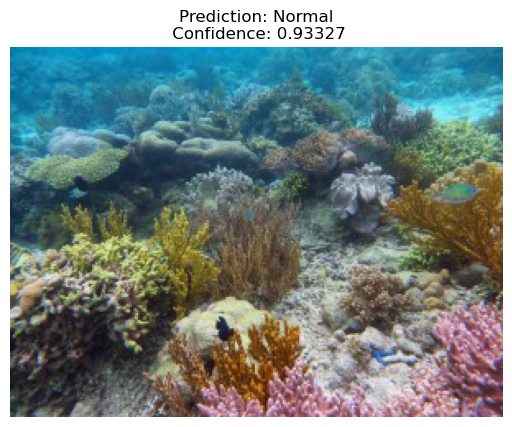

In [30]:
ground_truth_dataset = datasets.ImageFolder(root='data', transform = None)
i = 715
PIL_image = ground_truth_dataset[i][0]
y = ground_truth_dataset[i][1]
#provide any pil image
predict_fn(PIL_image)